In [ ]:
import pandas as pd
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/learn-want/mpl_style/main/uzh.mplstyle')
import warnings
# 忽略 pandas 警告
warnings.filterwarnings('ignore')

In [ ]:
from matplotlib import font_manager

font_dirs = ['/home/user/yan/Fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [ ]:
import vaex

In [ ]:

proposer_reward=vaex.from_csv('/local/scratch/exported/Ethereum_token_txs_data/rewards/slot_proposer_reward.csv')
proposer_reward['epoch']=proposer_reward['epoch'].astype('int64')
proposer_reward['epoch_v_index']=proposer_reward['epoch'].astype('str')+'_'+proposer_reward['proposer_index'].astype('int64').astype('str')
#有些节点可以在同一个 epoch 里面成为多个 proposer，所以需要把 proposer reward 按照 epoch_v_index 和 epoch 分组
proposer_reward1=proposer_reward.groupby(by=['epoch_v_index','epoch'], agg={'total': 'sum','attestations':'sum','sync_aggregate':'sum',
                                                 'proposer_slashings':'sum','attester_slashings':'sum'})

sync=vaex.from_csv('/local/scratch/exported/Ethereum_token_txs_data/rewards/sync_committee_reward.csv')
sync['epoch']=sync['epoch'].astype('int64')
sync['epoch_v_index']=sync['epoch'].astype('str')+'_'+sync['validator_index'].astype('int64').astype('str')
sync1=sync.groupby(by=['epoch_v_index','epoch'],agg={'reward':'sum'})



In [ ]:
proposer_reward[proposer_reward['epoch']==146885]

#,proposer_index,total,attestations,sync_aggregate,proposer_slashings,attester_slashings,slot,epoch,epoch_v_index
0,264543,28967231,27948731,1018500,0,0,4700320,146885,146885_264543
1,94282,27615381,26657991,957390,0,0,4700321,146885,146885_94282
2,327313,28667418,27644844,1022574,0,0,4700322,146885,146885_327313
3,135399,28723610,27705110,1018500,0,0,4700323,146885,146885_135399
4,111093,28562136,27551784,1010352,0,0,4700324,146885,146885_111093
...,...,...,...,...,...,...,...,...,...
27,248440,28816565,27800102,1016463,0,0,4700347,146885,146885_248440
28,186699,28738190,27727838,1010352,0,0,4700348,146885,146885_186699
29,4092,28768037,27751574,1016463,0,0,4700349,146885,146885_4092
30,166347,28664099,27653747,1010352,0,0,4700350,146885,146885_166347


In [ ]:
files=glob('/local/scratch/exported/Ethereum_token_txs_data/rewards/attestation_reward_*.csv')
for file in files:
    start_epoch=file.split('/')[-1].split('.')[0].split('_')[-2]
    end_epoch=file.split('/')[-1].split('.')[0].split('_')[-1]
    validator_reward=vaex.from_csv(file)
    validator_reward['total_reward']=validator_reward['head']+validator_reward['target']+validator_reward['source']
    validator_reward['epoch_v_index']=validator_reward['epoch'].astype('int64').astype('str')+'_'+validator_reward['validator_index'].astype('int64').astype('str')
    validator_reward_add_proposer=validator_reward.join(proposer_reward1, on='epoch_v_index', how='left', rsuffix='_proposer')
    validator_reward_add_proposer_sync=validator_reward_add_proposer.join(sync1, on='epoch_v_index', how='left', rsuffix='_sync')
    validator_reward_add_proposer_sync=validator_reward_add_proposer_sync.drop(['epoch_proposer','epoch_sync'])
    # validator_reward_add_proposer_sync.export_csv(f'/local/scratch/exported/Ethereum_token_txs_data/rewards/aggregated_rewards/aggregated_rewards_{start_epoch}_{end_epoch}.csv')



In [ ]:
sync[sync['epoch']==149877]

#,validator_index,reward,slot,epoch,epoch_v_index
0,424962,14420,4796064,149877,149877_424962
1,343041,14420,4796064,149877,149877_343041
2,196623,14420,4796064,149877,149877_196623
3,74771,14420,4796064,149877,149877_74771
4,302103,14420,4796064,149877,149877_302103
...,...,...,...,...,...
"16,379",85994,14420,4796095,149877,149877_85994
"16,380",350190,14420,4796095,149877,149877_350190
"16,381",78830,14420,4796095,149877,149877_78830
"16,382",223223,14420,4796095,149877,149877_223223


check total reward data by epoch

In [ ]:
check=vaex.open('/local/scratch/exported/Ethereum_token_txs_data/rewards/aggregated_rewards/aggregated_rewards_146875_147375.hdf5')
check.head(2)

#,validator_index,head,target,source,epoch,total_reward,epoch_v_index,epoch_v_index_proposer,total,attestations,sync_aggregate,proposer_slashings,attester_slashings,epoch_v_index_sync,reward
0,0,3625,7006,3768,146875,14399,146875_0,--,999999,999999,999999,999999,999999,--,999999
1,1,3625,7006,3768,146875,14399,146875_1,--,999999,999999,999999,999999,999999,--,999999


rename columns

In [ ]:
check.rename('total_reward',new_name='attestation_total_reward')
check.rename('total',new_name='proposer_total_reward')
check.rename('attestations',new_name='proposer_attestations')
check.rename('sync_aggregate',new_name='proposer_sync_aggregate')
check.rename('attester_slashings',new_name='proposer_attester_slashings')
check.rename('reward',new_name='sync_total_reward')



'sync_total_reward'

In [ ]:
check.head(2) #Names are revised

#,validator_index,head,target,source,epoch,attestation_total_reward,epoch_v_index,epoch_v_index_proposer,proposer_total_reward,proposer_attestations,proposer_sync_aggregate,proposer_slashings,proposer_attester_slashings,epoch_v_index_sync,sync_total_reward
0,0,3625,7006,3768,146875,14399,146875_0,--,999999,999999,999999,999999,999999,--,999999
1,1,3625,7006,3768,146875,14399,146875_1,--,999999,999999,999999,999999,999999,--,999999


fix 999999 error
每读取一个hdf5文件，应该执行下面操作

In [ ]:
#使用vaex将数据导出为 hdf5 的时候，如果 join 的时候是部分匹配上，再输出位 hdf5 格式时候，
#就会将缺失值补充为999999，这是格式问题，不是数据错误
#修正方式:
#如果epoch_v_index_proposer 为空，将 total 到attester_slashings 变为0
#如果epoch_v_index_sync 为空，将reward 变为0
check['proposer_total_reward'] = check.func.where(check.epoch_v_index_proposer.isna()==True, 0,check.proposer_total_reward)
check['proposer_attestations'] = check.func.where(check.epoch_v_index_proposer.isna()==True, 0,check.proposer_attestations)
check['proposer_sync_aggregate'] = check.func.where(check.epoch_v_index_proposer.isna()==True, 0,check.proposer_sync_aggregate)
check['proposer_slashings'] = check.func.where(check.epoch_v_index_proposer.isna()==True, 0,check.proposer_slashings)
check['proposer_attester_slashings'] = check.func.where(check.epoch_v_index_proposer.isna()==True, 0,check.proposer_attester_slashings)
check['sync_total_reward'] = check.func.where(check.epoch_v_index_sync.isna()==True, 0,check.sync_total_reward)
check.head(3)

#,validator_index,head,target,source,epoch,attestation_total_reward,epoch_v_index,epoch_v_index_proposer,proposer_total_reward,proposer_attestations,proposer_sync_aggregate,proposer_slashings,proposer_attester_slashings,epoch_v_index_sync,sync_total_reward,final_total_reward
0,0,3625,7006,3768,146875,14399,146875_0,--,0,0,0,0,0,--,0,14399
1,1,3625,7006,3768,146875,14399,146875_1,--,0,0,0,0,0,--,0,14399
2,2,3625,7006,3768,146875,14399,146875_2,--,0,0,0,0,0,--,0,14399


In [ ]:
#final_total_reward 是最终的 reward，包括 proposer reward， attestation reward， sync reward
check['final_total_reward']=check['attestation_total_reward']+check['proposer_total_reward']+check['sync_total_reward']
check.head(3)

#,validator_index,head,target,source,epoch,attestation_total_reward,epoch_v_index,epoch_v_index_proposer,proposer_total_reward,proposer_attestations,proposer_sync_aggregate,proposer_slashings,proposer_attester_slashings,epoch_v_index_sync,sync_total_reward,final_total_reward
0,0,3625,7006,3768,146875,14399,146875_0,--,0,0,0,0,0,--,0,14399
1,1,3625,7006,3768,146875,14399,146875_1,--,0,0,0,0,0,--,0,14399
2,2,3625,7006,3768,146875,14399,146875_2,--,0,0,0,0,0,--,0,14399


In [ ]:
check[check['proposer_total_reward']!=check['proposer_attestations']+check['proposer_sync_aggregate']+check['proposer_slashings']+check['proposer_attester_slashings']]
#It is right if the result is empty

#,validator_index,head,target,source,epoch,attestation_total_reward,epoch_v_index,epoch_v_index_proposer,proposer_total_reward,proposer_attestations,proposer_sync_aggregate,proposer_slashings,proposer_attester_slashings,epoch_v_index_sync,sync_total_reward,final_total_reward
,,,,,,,,,,,,,,,,


## missing blocks

In [ ]:
#每个 epoch 里面有多少个 proposer得到了奖励
proposer_rewards_number=proposer_reward.groupby(by=['epoch'], agg={'proposer_index': 'count'})
# 程序突然中断，最后一个 epoch 应该是没有完整数据，排除掉最后一个 epoch
proposer_rewards_number['missing_slots']=32-proposer_rewards_number['proposer_index']
proposer_rewards_number

#,epoch,proposer_index,missing_slots
0,146875,19,13
1,146876,32,0
2,146877,31,1
3,146878,31,1
4,146879,32,0
...,...,...,...
"7,442",154317,32,0
"7,443",154318,32,0
"7,444",154319,32,0
"7,445",154320,32,0


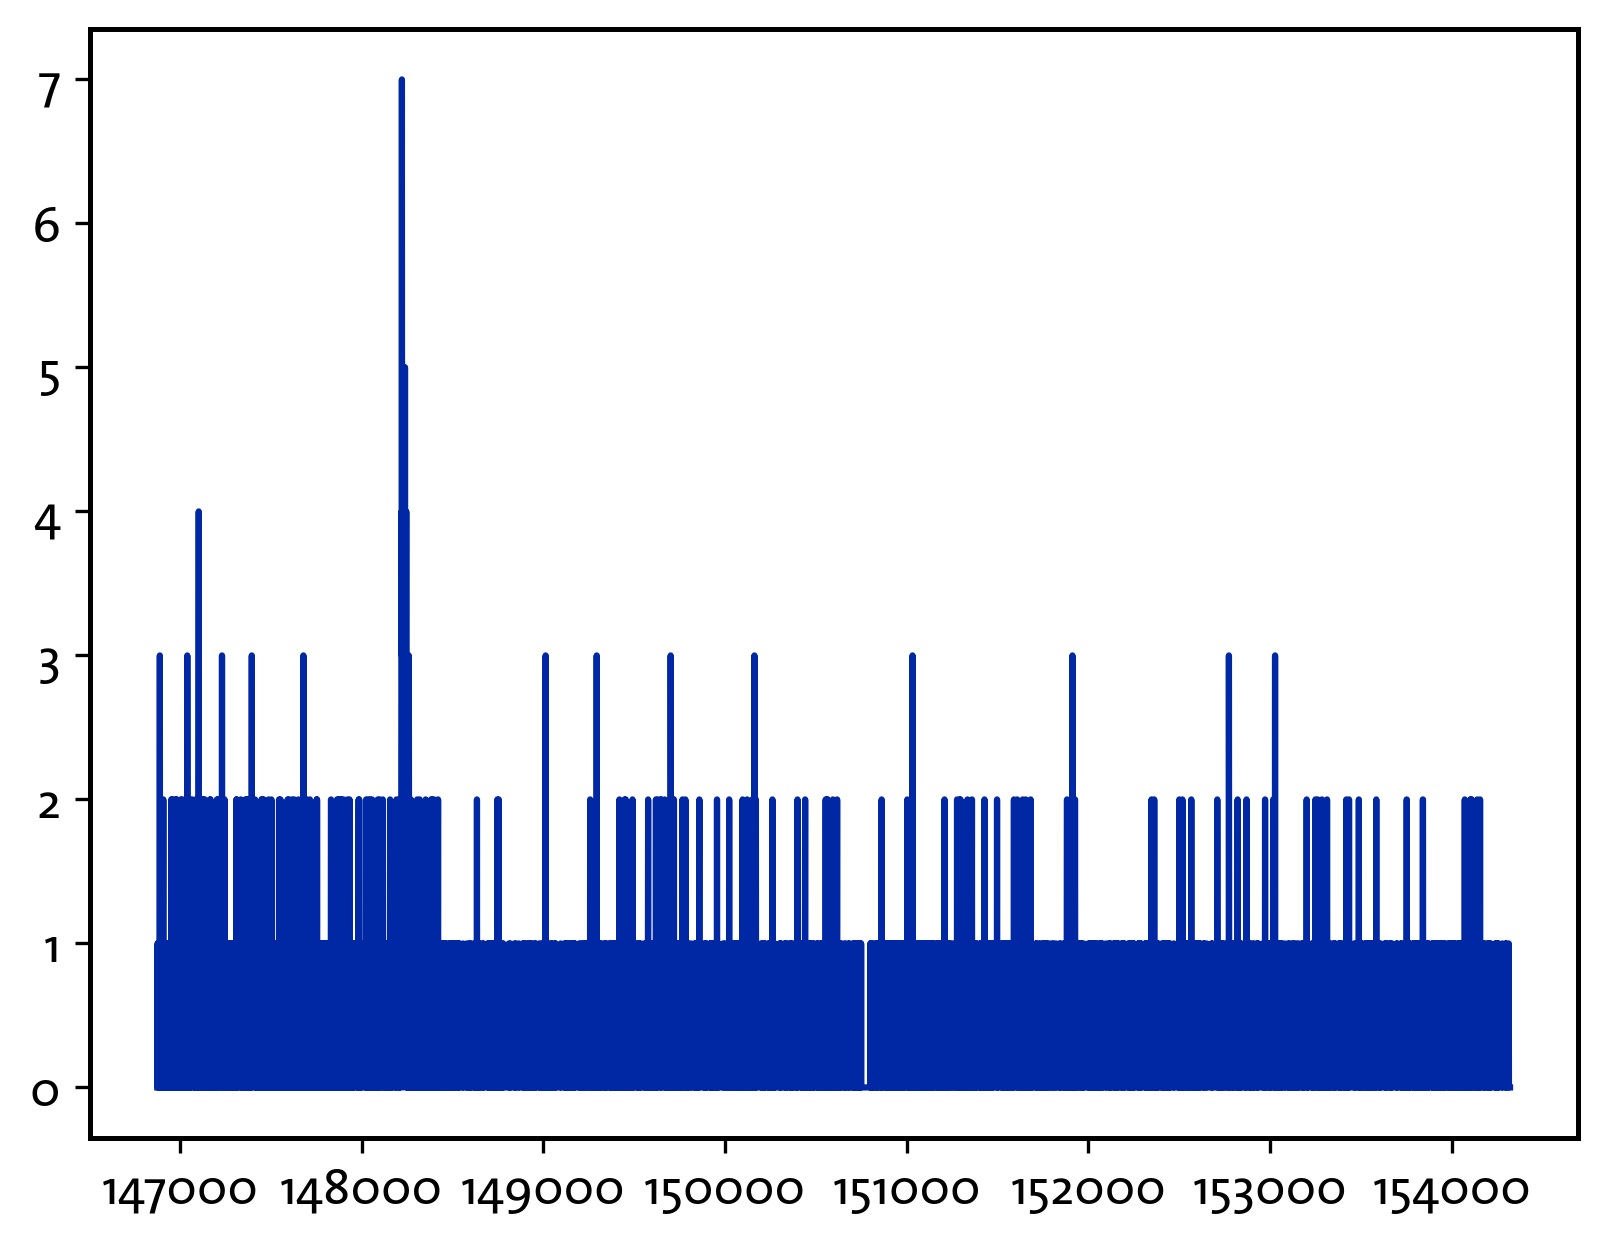

In [ ]:
#画堆积图
plt.plot(proposer_rewards_number['epoch'][1:-1],proposer_rewards_number['missing_slots'][1:-1],label='missing_slots')
#增加 x 轴标签
# plt.xlabel('Epoch')


